In [76]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime
import numpy as np
import random
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import json

In [77]:
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [78]:
class Neural_Network_Model():
    
    def __init__(self, X, Y, n_outputs, n_lag, n_ft, n_layer, batch, epochs, lr, Xval=None, Yval=None, patience=5, min_delta=0.001):
        lstm_input = Input(shape=(n_lag, n_ft))
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)
        dense_output = Dense(n_outputs)(lstm_layer)
        
        self.model = Model(inputs=lstm_input, outputs=dense_output)
        self.batch = batch
        self.epochs = epochs
        self.lr = lr
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.patience = patience
        self.min_delta = min_delta

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        optimizer = Adam(learning_rate=self.lr)
        self.model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)
        history = self.model.fit(self.X, self.Y, epochs=self.epochs, batch_size=self.batch, validation_data=(self.Xval, self.Yval), callbacks=[self.trainCallback()])
        return history

    def predict(self, X):
        return self.model.predict(X)

In [79]:
#2005 file
df1=pd.read_csv('eplusout2005.csv',sep=',',decimal=',',index_col=0, low_memory=False)

df1 = df1.filter(['DistrictCooling:Facility [J](Hourly)','Electricity:Facility [J](Hourly)','DistrictHeating:Facility [J](Hourly)'])
df1=df1.reset_index()
data1 = df1['Date/Time'].tolist()

for i in range(0, len(data1)):
    data1[i] = str(data1[i]).replace(str(data1[i]), '05/' + str(data1[i]).strip())


new_df1={}
new_df1['Date/Time']=data1
new_df1['DistrictCooling:Facility [J](Hourly)']= df1['DistrictCooling:Facility [J](Hourly)'].tolist()
new_df1=pd.DataFrame(new_df1)
new_df1.set_index("Date/Time", inplace = True)

In [80]:
#2012 file

df2=pd.read_csv('eplusout2012.csv',sep=',',decimal=',',index_col=0, low_memory=False)
df2 = df2.filter(['DistrictCooling:Facility [J](Hourly)','Electricity:Facility [J](Hourly)','DistrictHeating:Facility [J](Hourly)'])
df2=df2.reset_index()
data2 = df2['Date/Time'].tolist()

for i in range( 0, len(data2)):
    data2[i] = data2[i].replace( str(data2[i]), '12/'+ str(data2[i]).strip())

new_df2={}
new_df2['Date/Time']=data2
new_df2['DistrictCooling:Facility [J](Hourly)']= df2['DistrictCooling:Facility [J](Hourly)'].tolist()
new_df2=pd.DataFrame(new_df2)
new_df2.set_index("Date/Time", inplace = True)

In [82]:
dftot=pd.concat([new_df1, new_df2])
d = dftot.filter(['DistrictCooling:Facility [J](Hourly)'])
d=d.reset_index()

In [83]:
d['DistrictCooling:Facility [J](Hourly)']= d['DistrictCooling:Facility [J](Hourly)'].astype(float)
d.dtypes

# Features used in models
features = ['DistrictCooling:Facility [J](Hourly)']

# Aggregating to hourly level
d = d.groupby('Date/Time', as_index=False)[features].mean()
d[features].describe()

,DistrictCooling:Facility [J](Hourly)
count,2.628000e+04
mean,1.668245e+06
std,5.074325e+06
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,3.974123e+07


In [84]:
# Number of lags (hours back) to use for models
lag = 72
# Steps ahead to forecast 
n_ahead = 3
# Share of obs in testing 
test_share = 0.34
# Epochs for training
epochs = 60
# Batch size 
batch_size = 64
# Learning rate
lr = 0.001
# Number of neurons in LSTM layer
n_layer = 50
# The features used in the modeling 
features_final = ['DistrictCooling:Facility [J](Hourly)']

In [85]:
# Subseting only the needed columns 
ts = d[features_final]

nrows = ts.shape[0]

# Spliting into train and test sets
train = ts[0:int(nrows * (1 - test_share))].astype('float')
test = ts[int(nrows * (1 - test_share)):].astype('float')

# Scaling the data 
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

# Creating the final scaled frame 
ts_s = pd.concat([train, test])

X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)
n_ft = X.shape[2]

# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

In [86]:
model = Neural_Network_Model(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,           # Number of forecast steps ahead
    n_lag=lag,                   # Number of lags used as input
    n_ft=Xtrain.shape[2],        # Number of features (usually derived from Xtrain)
    n_layer=50,                  # Number of LSTM units
    batch=batch_size,            # Batch size for training
    epochs=epochs,               # Number of epochs for training
    lr=0.001,                    # Learning rate
    Xval=Xval,
    Yval=Yval,
    patience=10,                 # Customize patience
    min_delta=0.0001             # Customize minimum delta
)

In [87]:
model.model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 72, 1)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 50)                10400     
                                                                 
 dense_6 (Dense)             (None, 3)                 153       
                                                                 
Total params: 10,553
Trainable params: 10,553
Non-trainable params: 0
_________________________________________________________________


In [88]:
history = model.train()

Epoch 1/60
271/271 [==============================] - 6s 19ms/step - loss: 0.2794 - val_loss: 0.2252
Epoch 2/60
271/271 [==============================] - 5s 17ms/step - loss: 0.1793 - val_loss: 0.1787
Epoch 3/60
271/271 [==============================] - 5s 17ms/step - loss: 0.1544 - val_loss: 0.1276
Epoch 4/60
271/271 [==============================] - 5s 17ms/step - loss: 0.1229 - val_loss: 0.1035
Epoch 5/60
271/271 [==============================] - 5s 17ms/step - loss: 0.1058 - val_loss: 0.0994
Epoch 6/60
271/271 [==============================] - 5s 19ms/step - loss: 0.0984 - val_loss: 0.0884
Epoch 7/60
271/271 [==============================] - 6s 20ms/step - loss: 0.0938 - val_loss: 0.0874
Epoch 8/60
271/271 [==============================] - 5s 17ms/step - loss: 0.0909 - val_loss: 0.0856
Epoch 9/60
271/271 [==============================] - 5s 17ms/step - loss: 0.0855 - val_loss: 0.0807
Epoch 10/60
271/271 [==============================] - 5s 17ms/step - loss: 0.0817 - val_lo

In [89]:
loss = history.history['loss']
val_loss = history.history['val_loss']

print("Training Loss:", loss)
print("Validation Loss:", val_loss)

Training Loss: [0.27937018871307373, 0.17930735647678375, 0.15443691611289978, 0.12285120785236359, 0.10577532649040222, 0.09844532608985901, 0.09379409998655319, 0.09090721607208252, 0.08551929891109467, 0.08173775672912598, 0.07690902054309845, 0.07645717263221741, 0.07423657178878784, 0.07161570340394974, 0.06812868267297745, 0.0673903077840805, 0.06522823125123978, 0.06520509719848633, 0.06306115537881851, 0.06178604066371918, 0.06329038739204407, 0.06072644144296646, 0.060438159853219986, 0.06073225662112236, 0.05985958129167557, 0.05923077464103699, 0.05876589193940163, 0.05858628824353218, 0.05730609595775604, 0.05681239068508148, 0.05749671161174774, 0.057637836784124374, 0.05642671883106232, 0.05691199749708176, 0.055920541286468506, 0.055839475244283676, 0.0556238554418087, 0.05466542765498161, 0.05555777996778488, 0.05535174161195755, 0.0536358468234539, 0.05439845845103264, 0.05369001254439354, 0.05392429232597351, 0.05411694943904877, 0.05274874344468117, 0.052393924444913

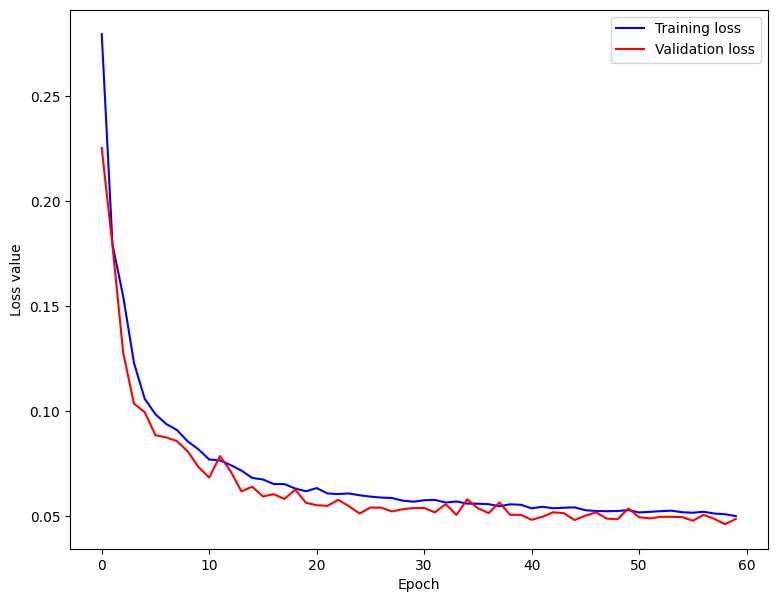

In [90]:
n_epochs = range(len(loss))
plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss,label='Training loss', color='blue')
plt.plot(n_epochs, val_loss,label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.savefig('Test2.png', dpi=600)
plt.show()

In [91]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model.predict(Xval)]
y = [y[0] for y in Yval]

# Creating the frame to store both predictions
days = d['Date/Time'].values[-len(y):]

frame = pd.concat([
    pd.DataFrame({'day': days, 'temp': y, 'type': 'original'}),
    pd.DataFrame({'day': days, 'temp': yhat, 'type': 'forecast'})
])

# Creating the unscaled values column
frame['temp_absolute'] = [(x* train_std['DistrictCooling:Facility [J](Hourly)'] )+ train_mean['DistrictCooling:Facility [J](Hourly)']  for x in frame['temp']] 

# Computation of temp results
temp_res = frame.pivot_table(index='day', columns='type')
temp_res.columns = ['_'.join(x).strip() for x in temp_res.columns.values]
temp_res['res'] = temp_res['temp_absolute_original'] - temp_res['temp_absolute_forecast']
temp_res['res_abs'] = [abs(x) for x in temp_res['res']]
temp_res.res_abs.describe()

# Forecasting on all the samples in the validation set 
forecast = model.predict(Xval)

279/279 [==============================] - 1s 4ms/step


In [92]:
print("Scaled Predictions: ", forecast[:5])
print("Scaled Actuals: ", Yval[:5])

Scaled Predictions:  [[-0.32603177 -0.32509136 -0.3270431 ]
 [-0.32603177 -0.32509136 -0.3270431 ]
 [-0.32603177 -0.32509136 -0.3270431 ]
 [-0.32603177 -0.32509136 -0.3270431 ]
 [-0.32603177 -0.32509136 -0.3270431 ]]
Scaled Actuals:  [[-0.3241094 -0.3241094 -0.3241094]
 [-0.3241094 -0.3241094 -0.3241094]
 [-0.3241094 -0.3241094 -0.3241094]
 [-0.3241094 -0.3241094 -0.3241094]
 [-0.3241094 -0.3241094 -0.3241094]]


In [93]:
# Reverse scaling to check actual vs predicted values
unscaled_predictions = [(x * train_std['DistrictCooling:Facility [J](Hourly)']) + train_mean['DistrictCooling:Facility [J](Hourly)'] for x in forecast.flatten()]
unscaled_actuals = [(x * train_std['DistrictCooling:Facility [J](Hourly)']) + train_mean['DistrictCooling:Facility [J](Hourly)'] for x in Yval.flatten()]

In [ ]:
print("Unscaled Predictions: ", unscaled_predictions[:5])
print("Unscaled Actuals: ", unscaled_actuals[:5])

In [95]:
# Calculating the total average absolute error 
error = 0 
n=0
residuals = []
error_mse=0

for i in range(Yval.shape[0]):
    true = Yval[i]
    hat = forecast[i]
    n += len(true)
    
    true = np.asarray([(x * train_std['DistrictCooling:Facility [J](Hourly)']) + train_mean['DistrictCooling:Facility [J](Hourly)'] for x in true])
    hat = np.asarray([(x * train_std['DistrictCooling:Facility [J](Hourly)']) + train_mean['DistrictCooling:Facility [J](Hourly)'] for x in hat])
       
    residual = true - hat
    residuals.append(residual)
    
    error += np.sum([abs(x) for x in true - hat]) 
    error_mse += np.sum([pow(x,2) for x in true - hat]) 

In [96]:
# Flattening the list of arrays of residuals
residuals = np.asarray(residuals).flatten().tolist()
abs_residuals = [abs(x) for x in residuals]
mse_residuals = [pow(x,2) for x in residuals]

In [97]:
Median_absoulte_error=round(np.median(abs_residuals), 2)
Mean_absoulte_error= round(np.mean(abs_residuals), 2)
Mean_square_error=round(np.mean(mse_residuals), 2)
Root_mean_square_error=round(np.sqrt(np.mean(mse_residuals)), 2)

In [ ]:
print("**************************FINAL RESULTS*************************************")
print("Median absoulte error: " + str( Median_absoulte_error )+"°C")
print("Mean absoulte error: "+ str(Mean_absoulte_error)+"°C")
print("Mean square error: " + str(Mean_square_error) + "°C")
print("Root mean squareerror: " + str(Root_mean_square_error) + "°C")

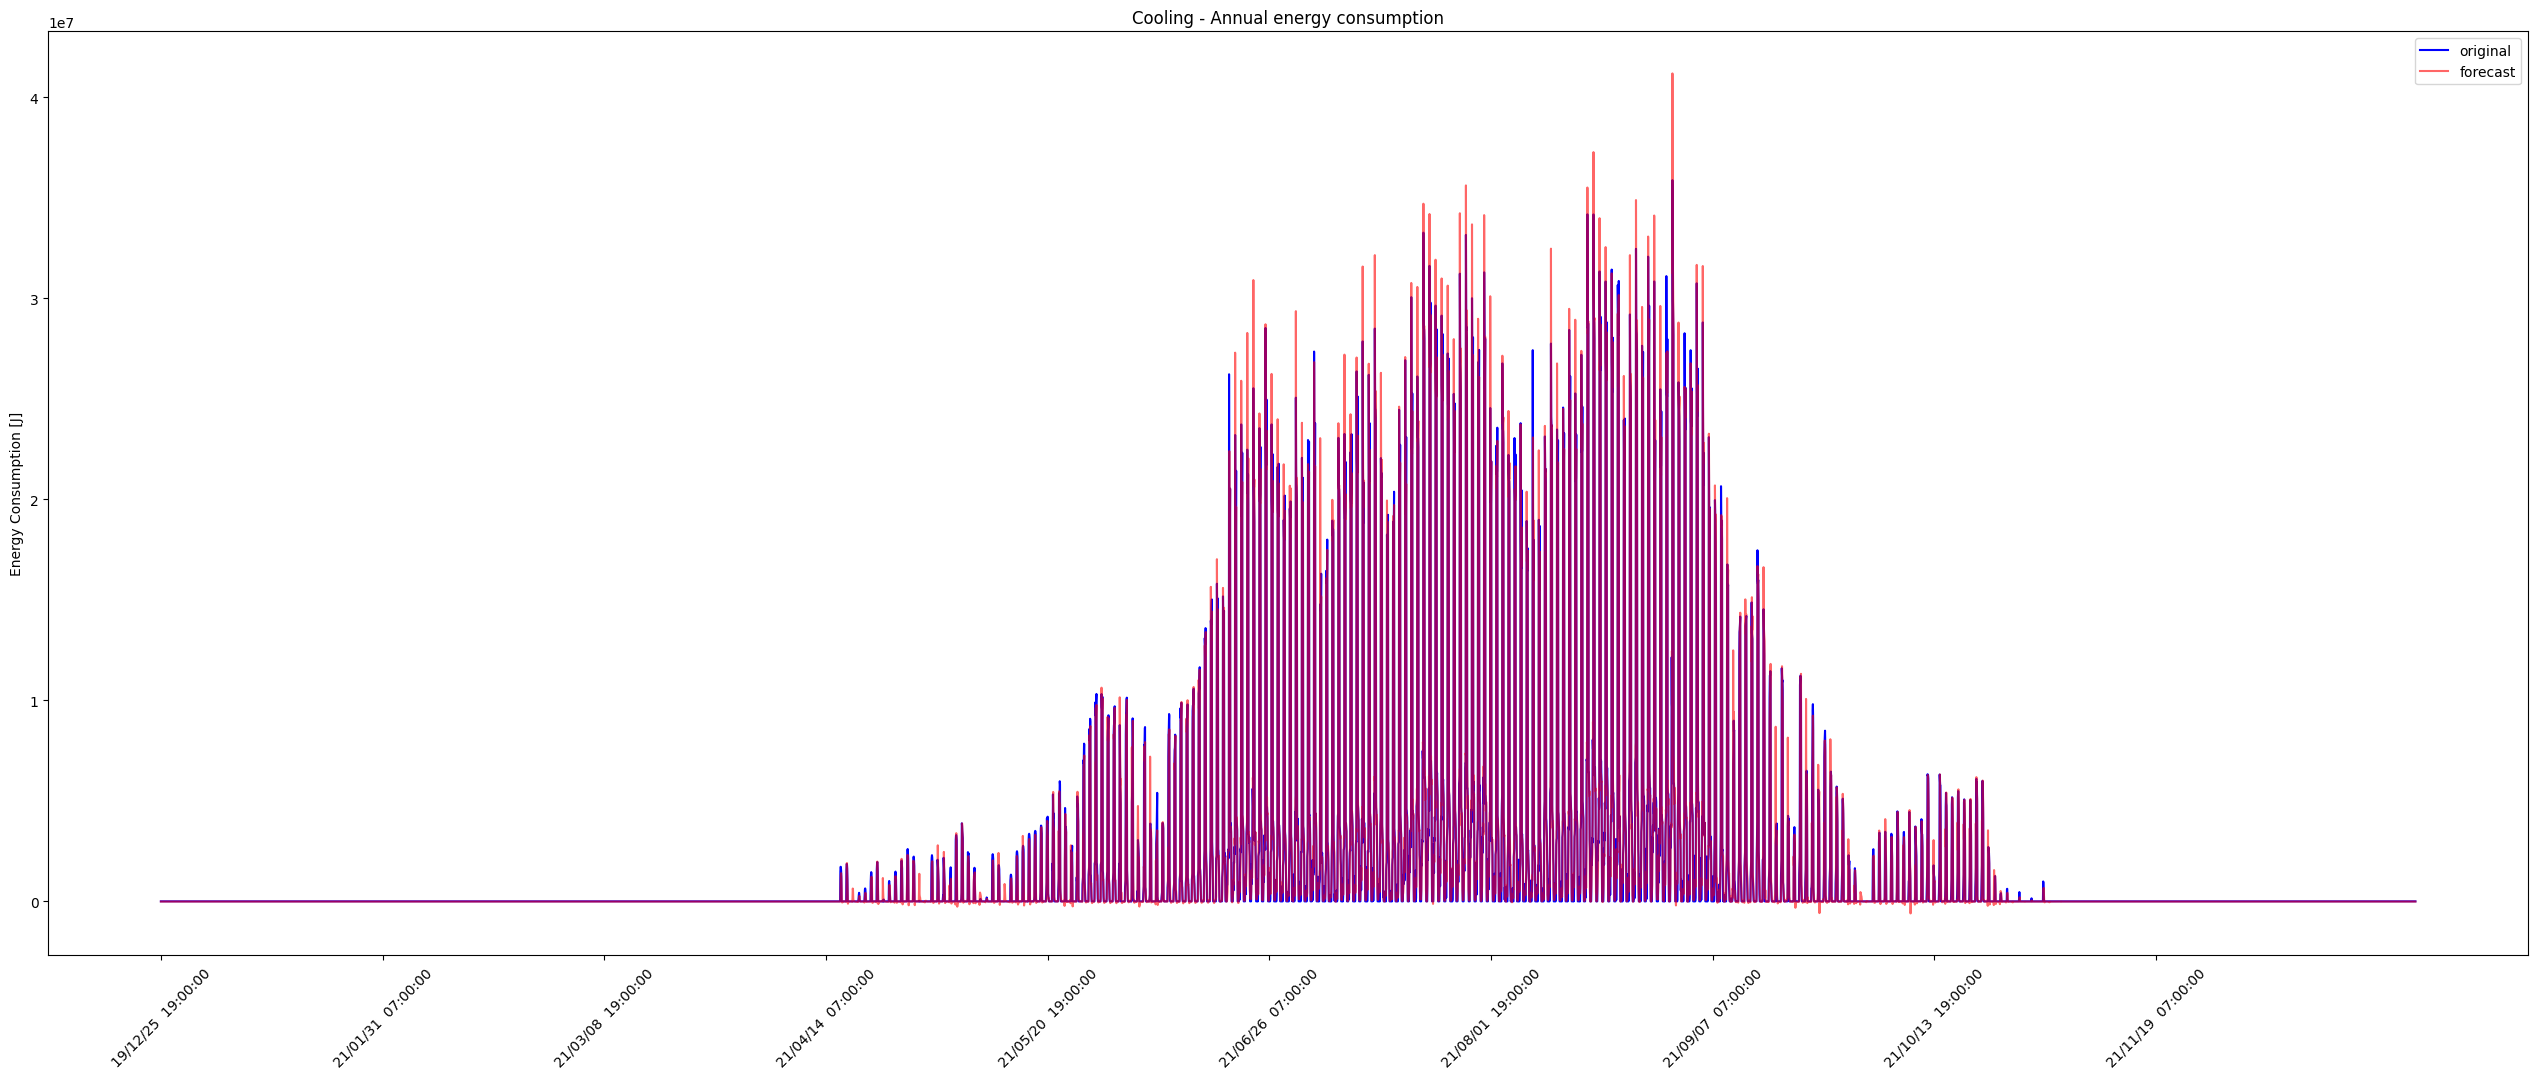

In [108]:
plt.figure(figsize=(32, 12))
plt.plot(temp_res.index, temp_res.temp_absolute_original, color='blue', label='original')
plt.plot(temp_res.index, temp_res.temp_absolute_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Cooling - Annual energy consumption')
plt.ylabel('Energy Consumption [J]')
plt.xticks(np.arange(0,8760,876), rotation=45)
plt.legend()
plt.savefig('cooling.png', dpi=600)
plt.show()